## AirBnB Reservation Prices Analysis

### Introduction

Finding an accomodation is the most typical problem to be solved, when travelling to other city or country. And one of the most important things in choosing an accomodation is the reservation price. What are the main factors, which affect the reservation prices? Does time of the year influence prices and what are the busiest times of the year to visit particular city? How can we save money on the reservation?

Fortunately, we can try to answer these questions by analysing publicly accessible AirBnB data, available on Inside AirBnB and on Kaggle.
Initial Insights

Before diving deep into data, let's find out some general information on how the reservation price is determined and search for some useful facts for the future analysis.

AirBnB reservation price is based on following costs (according to AirBnB official website information):

    Costs determined by the host:
        Nightly price: Nightly rate decided by the host;
        Cleaning fee: One-time fee charged by some hosts to cover the cost of 
        cleaning their space;
        Extra guest fees: One-time fee charged by some hosts to cover other costs related to using their space;
    Costs determined by Airbnb: Airbnb service fee;
    Other costs that may be included: currency exchange fees, VAT, other local taxes etc.

In our analysis we will concentrate on the factors, which influence the nightly price, determined by the host. Actually, AirBnB already has an algorithm, which suggests hosts the price. The approach for the algorithm and challenges are described in the article here. We can also use the information from the article in our analysis:

    Time of the year, when reservation is made, affects the price;
    Amenities offered like Wi-Fi and TV should be considered in the analysis, as they also might have great influence on price;
    It is better to use neighbourhood information rather then exact coordinates to describe the listing location, because sometimes even close locations might have huge difference in listing prices, if they belong to different neighbourhoods or are located different sides of the river.

### Approach

    The first look at the data:
        what information we have?
        what information is missing?
        discover general facts: time period, total number of listings in the dataset,
    Initial data preparation:
        remove the irrelevant information;
        reformat the information and imputing missing values;
    High level analysis:
        find out high level trends and correlations;
    Use machine learning for further analysis.


### The First Look at the Data

AirBnB provided us with 3 datasets for Seattle:

    listings.csv - summary information on listing in Seattle such as: location, host information, cleaning and guest fees, amenities etc.
    
    calendar.csv - calendar data for the listings: availability dates, price for each date.
    
    reviews.csv - summary review data for the listings. This dataset won't be used in further analysis.


In [1]:
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

In [2]:
listing_df = pd.read_csv('./data/listings.csv')
listing_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [3]:
listing_number = listing_df['id'].count()
hosts_number = len(listing_df['host_id'].unique())

print("listings.csv datasets contains information on %d listings provided by %d hosts." %(listing_number,hosts_number))

listings.csv datasets contains information on 3818 listings provided by 2751 hosts.


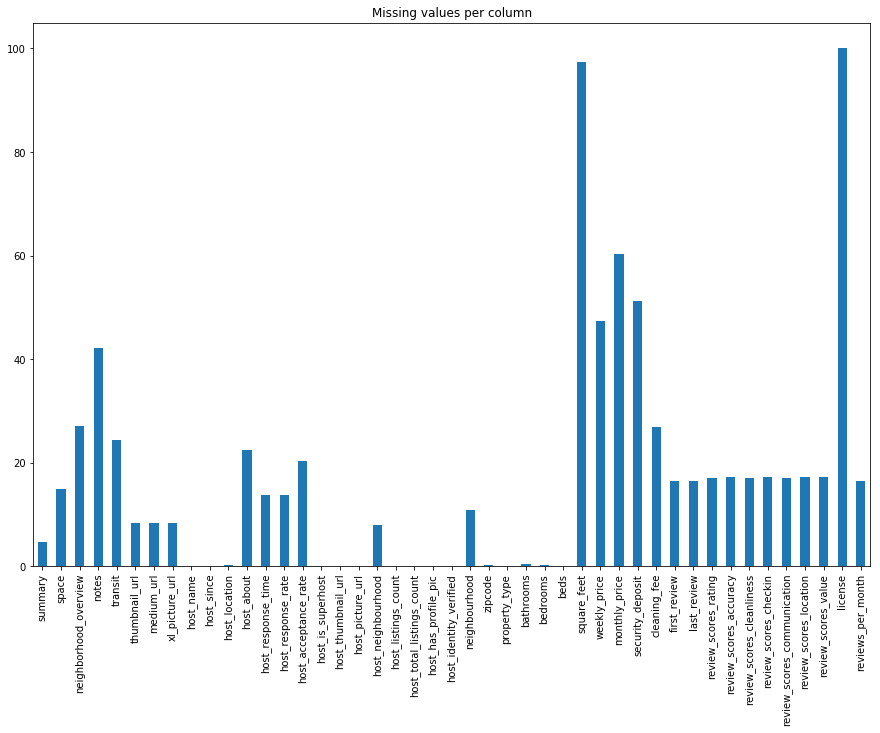

In [4]:
# percentage of missing values in each column 
listing_missing_values = listing_df.isnull().mean()*100

listing_columns_with_nan = listing_missing_values[listing_missing_values > 0]

listing_columns_with_nan.plot.bar(title="Missing values per column", figsize=(15,10));



As we see on the diagram above, we don't have information on each listing license and on amount of square feets for each listing. We can also see that there are more than 40% of missing values for weekly price, monthly price and security deposit, but we are not going to use these data in our analysis anyway, because it will obviously lead to overfitting our machine learning model.


> Statistics for calendar.csv dataset:

In [5]:
calendar_df = pd.read_csv('./data/calendar.csv')
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [6]:
rows_num = calendar_df.shape[0]

#find first and last date of the calendar
min_date = calendar_df['date'].min()
max_date = calendar_df['date'].max()

print('calendar.csv dataset contains %d rows.' % (rows_num))
print('The first date of observation is %s and the last date is %s.' % (min_date, max_date))

calendar.csv dataset contains 1393570 rows.
The first date of observation is 2016-01-04 and the last date is 2017-01-02.


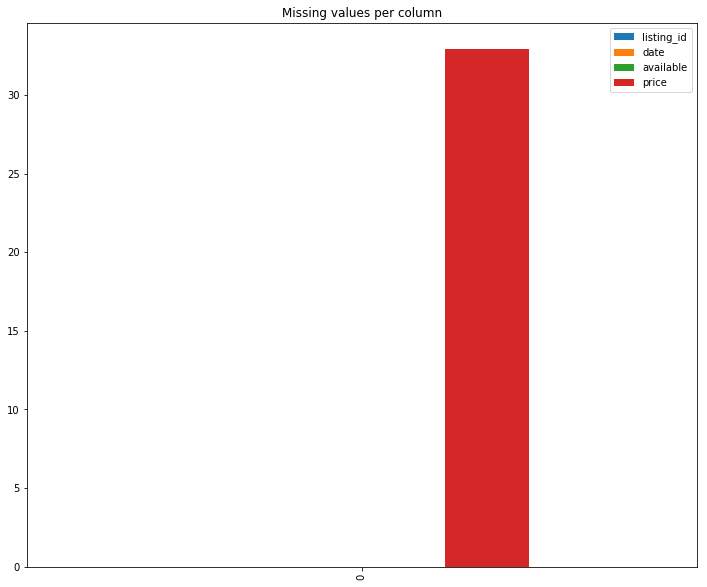

In [7]:
# percentage of missing values
calendar_missing_df = pd.DataFrame([calendar_df.isnull().mean()*100])
calendar_missing_df.plot.bar(title="Missing values per column", figsize=(12,10))

> As we see on digram, there are only 32% percent of missing values for price column for dates, when the listing was unavailable.

### Initial Data Preparation



Before trying to get the first outcomes, the data should be pre-processed:

- datasets should be merged into one using the listing identifier;
    
- irrelevant columns and columns, which contain missing data should be removed from the analysis;
    
- dates and prices should be converted from text into numbers.



In [8]:
#Helper functions for dataset cleaning

def get_month_from_date(row):
    ''' Get month from date represented as a string '''
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    ''' Get year from date represented as a string '''
    return int(row['date'].split('-')[0])

def get_host_since_year(row):
    ''' Get year from a date represented as a string '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

def get_val_from_list(row, column_name, value):
    ''' Fill in dummy column for values '''
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' Split values in columns, which contain lists (for example, amenities) '''
    
    # get dictionary of unique values in lists across dataset rows
    values_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
      
    # split into columns
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)
        
    return

def get_extra_people_fee(row):
    ''' Return 1 when the is fee for exatra people '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0

In [9]:
#Main dataset cleaning function
def clean_dataset(listings_df, calendar_df):
    '''
    INPUT
    listings_df - pandas dataframe containing listings data 
    calendar_df - pandas dataframe containing calendar data
    
    OUTPUT
    df - cleaned dataset, which contains merged tables:
    1. irrelevant columns are dropped;
    2. string containing dates are converted into numbers;
    3. columns, containing lists, are split into several columns (for example, amenities)
    4. missing values are imputed with mean or mode.
    '''
    #merge datasets
    listings_df = listings_df.rename(index=str, columns={"id": "listing_id"})
    df = pd.merge(calendar_df, listings_df, on = 'listing_id')
    
    #drop the irrelevant columns
    columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'cleaning_fee', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                   'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                   'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
                   'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
                  'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
                  'reviews_per_month']
    df = df.drop(columns = columns_to_drop)
    
    #convert date from the calendar into month and drop the date colum
    df['month'] = df.apply(lambda row: get_month_from_date(row),axis=1)
    df['year'] = df.apply(lambda row: get_year_from_date(row),axis=1)
    df = df.drop(columns = ['date'])
    
    #remove rows where price_x == nan, because price will be used as response column
    df = df.dropna(subset=['price_x'])
    
    #convert price to number and drop the price_x column
    df['price'] = df['price_x'].astype(str)
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df = df.drop(columns = ['price_x'])
    
    #convert host_since date into number and fill in missing values, drop the original column
    df['host_since_year'] = df.apply(lambda row: get_host_since_year(row),axis=1)
    df['host_since_year'].fillna(df['host_since_year'].mean(), inplace = True)
    df = df.drop(columns = ['host_since'])
    
    #convert host_response_rate into number and fill in missing values, drop the original column
    df['host_response_rate_num'] = df['host_response_rate'].astype(str)
    df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
    df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)
    
    df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')
    
    df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])
    
    #fill missing values with mean value for host_listings_count
    df['host_listings_count'].fillna(df['host_listings_count'].mean(), inplace = True)
    
    #split host_verifications into dummy columns and drop the original column
    split_list_into_columns(df, 'host_verifications')
    df = df.drop(columns = ['host_verifications'])
    
    #fill in missing values for bathrooms, bedrooms and beds with mode
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
    df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
    
    #split amenities into dummy columns and drop the original column
    split_list_into_columns(df, 'amenities')
    df = df.drop(columns = ['amenities'])
    
    #turn extra people fee into binary column (1 - if fee for extra people is charged, 0 - otherwise)
    df['extra_people_fee'] = df.apply(lambda row: get_extra_people_fee(row),axis=1)
    df = df.drop(columns = ['extra_people'])
    
    #fill missing values for review scores columns
    review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
    for column in review_scores_columns:
        df[column].fillna(df[column].mean(), inplace = True)
    
    return df

In [10]:
# clean datasets
df = clean_dataset(listing_df, calendar_df)

### Analysis

In [11]:
# listing prices overview
min_price = df['price'].min()
max_price = df['price'].max()
mean_price = df['price'].mean()

print("Maximum price per listings in $:",max_price)
print("Minimum price per listings in $:",min_price)
print("Mean price per listing in $:",mean_price)

Maximum price per listings in $: 1650.0
Minimum price per listings in $: 10.0
Mean price per listing in $: 137.94485855103355


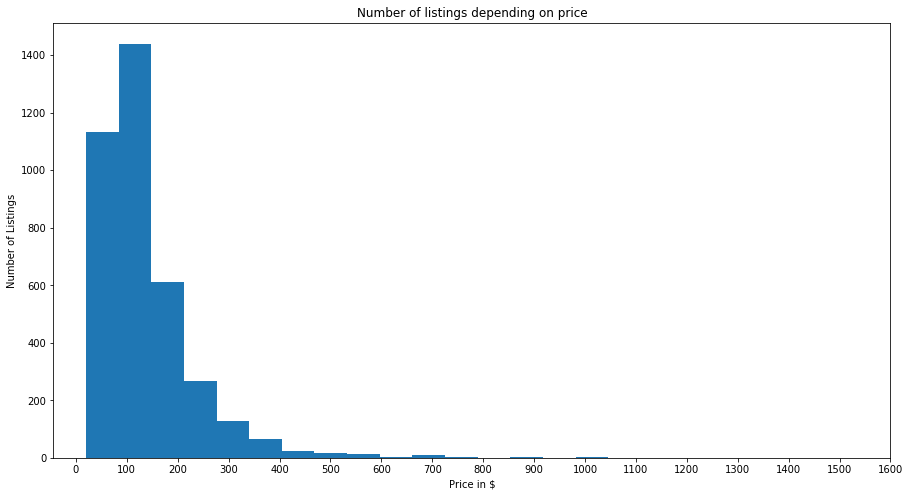

In [12]:
# average price for each listing
average_listing_price = df.groupby('listing_id').mean()['price']

plt.figure(figsize=(15,8))
plt.hist(average_listing_price, bins=20)
plt.xticks(np.arange(0, 1700, step=100))
plt.ylabel("Number of Listings")
plt.xlabel("Price in $")
plt.title("Number of listings depending on price")
plt.show()



> Now we see the distribution of average listing prices. The majority of listings is concentrated around 50 - 150 USD.


##### What Are the Busiest Times of the Year to Visit Seattle?

To answer this question we should look at:

- how the number of listings change depending on time of the year?
- how prices change depending on time of time of the year?



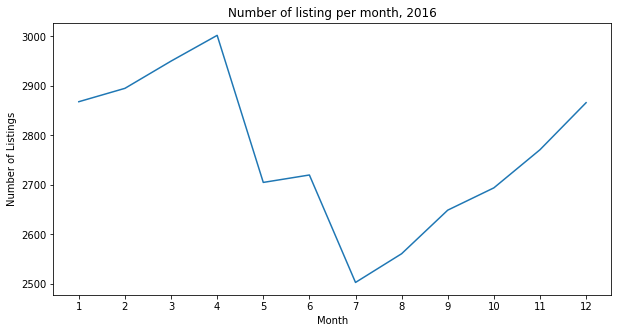

In [13]:
number_listing_by_month = pd.Series([12])

for i in range(1,13):
    number_listing_by_month[i] = len(df[(df['month'] == i) & (df['year'] == 2016)]['listing_id'].unique())

number_listing_by_month = number_listing_by_month.drop(0)

plt.figure(figsize=(10,5))
plt.plot(number_listing_by_month)
plt.xticks(np.arange(1,13, step=1))
plt.ylabel("Number of Listings")
plt.xlabel("Month")
plt.title("Number of listing per month, 2016")
plt.show()

> The diagram above shows us number of listings depending on month. We can see that number of available listings for reservation is tends to be the lowest in summer.


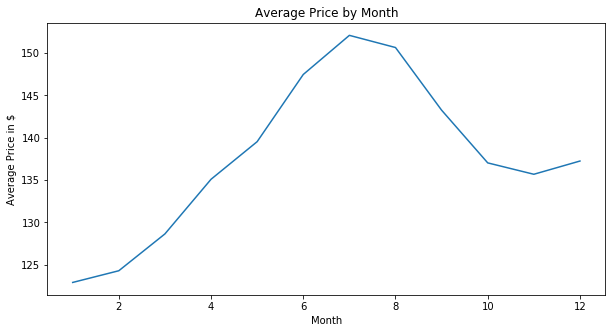

In [14]:
# average price by month
average_price_month = df.groupby(['month'])['price'].mean()

plt.figure(figsize=(10,5))
plt.plot(average_price_month)
plt.title("Average Price by Month")
plt.ylabel("Average Price in $")
plt.xlabel("Month")
plt.show()

> According to the diagram above listing prices raise significantly in summer, probably, because of the fact that there are less listings available for reservation. There is also a raise in December. This tells us that summer and winter holidays should be the busiest times to visit Seattle.


##### Prices Depending on Neighbourhood

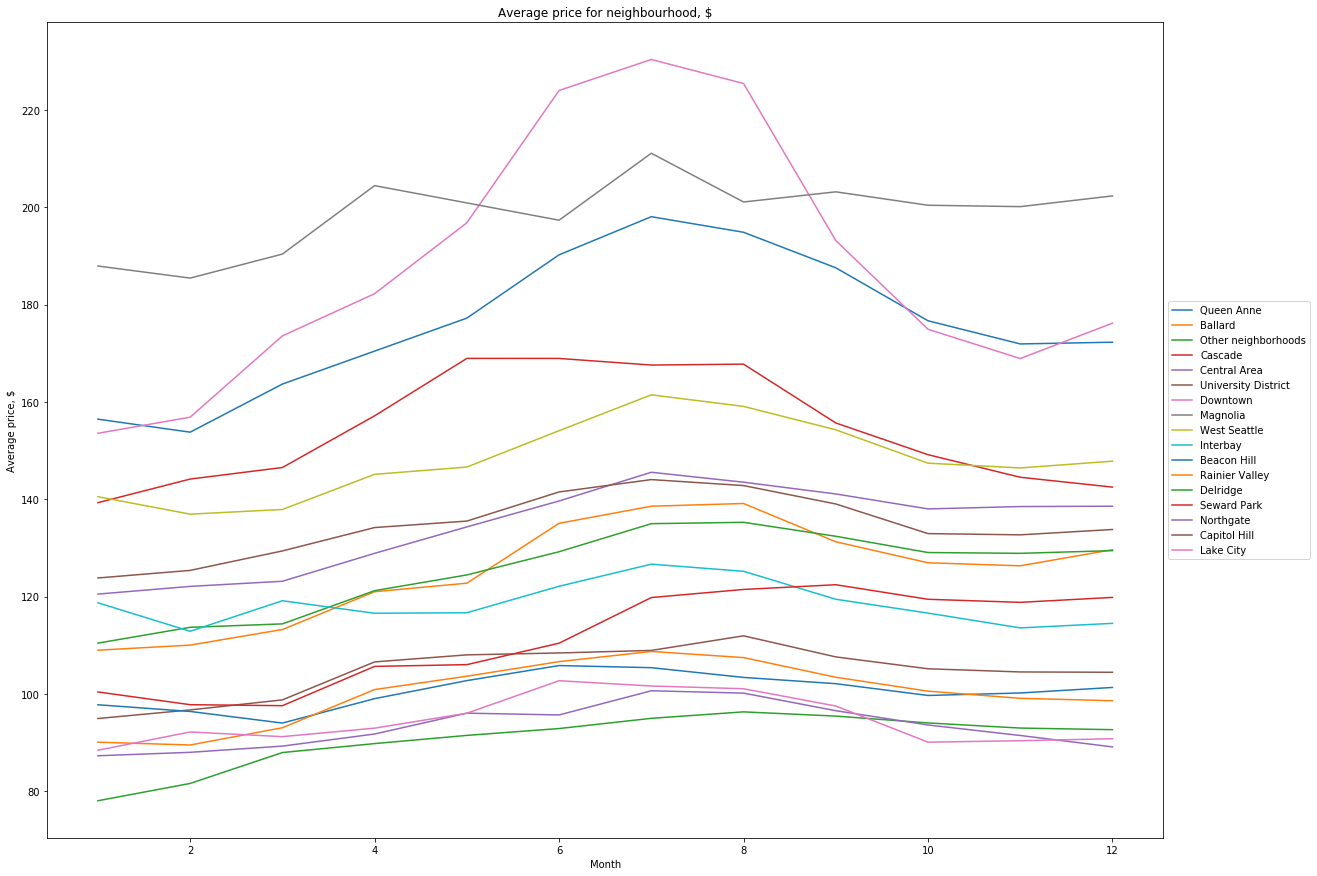

In [18]:
neighbourhoods = df['neighbourhood_group_cleansed'].unique()

price_by_month_neighbourhood = df.groupby(['month', 'neighbourhood_group_cleansed']).mean().reset_index()

# plot prices for neighbourhood
fig = plt.figure(figsize=(25,15))
ax = plt.subplot(111)

for neighbourhood in neighbourhoods:
    ax.plot(price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['month'],
               price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['price'],
             label = neighbourhood)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price for neighbourhood, $')

plt.savefig('average price for neighbourhood')

plt.show()

> On the diagram above we can see that prices differ depending on the location (neighbourhood). The highest average prices are in Downtown, which is not surprising. But for each neighbourhood prices tend to raise in summer.

##### Correlation between Price and Other Features

It is useful to look on correlations between price and other features from the dataset to find factors, which influence the price.


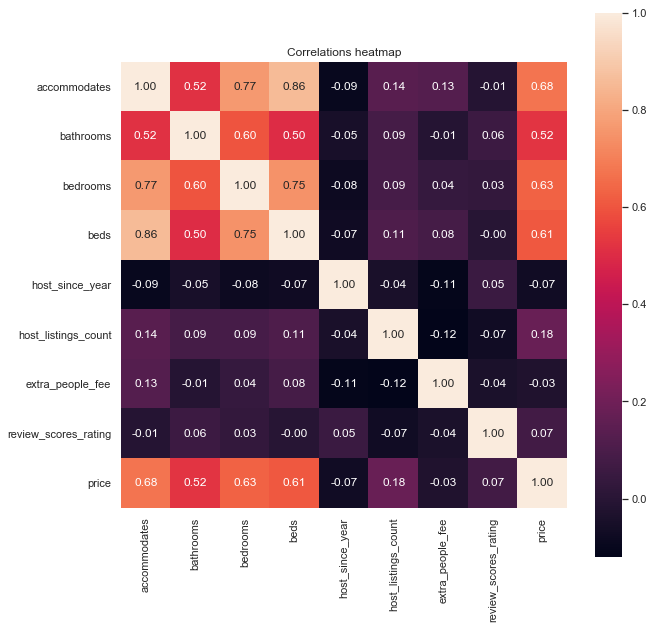

In [20]:
#Numerical columns to find out correlation
cols = ['accommodates','bathrooms','bedrooms','beds','host_since_year',
        'host_listings_count', 'extra_people_fee',
        'review_scores_rating', 'price']

corrs = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize': (10,10)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap')

fig = hm.get_figure()

> From the correlations heatmap diagram we can see that price is correlated with number of accomodates, bathrooms, bedrooms and beds. We also see that these features are correlated themselves. In fact, these results are quite obvious, because the price really depends on how large is the place.

### Machine Learning



Additionally we are able to apply machine learning methods to see which features in dataset influence the price the most. In order to do this we will train two popular models (Random Forest regressor and XGBoost regressor) based on decision trees and look at resulting feature importances.


In [ ]:
# turn categorical columns into dummies
cat_columns = 